## Global Suicide Analysis & Prediction Model ##
This project takes in the ['Suicide Rates Overview 1985 to 2016' dataset](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016), which itself is 'pulled from four other datasets', referenced as below in the dataset description: 

1. United Nations Development Program. (2018). Human development index (HDI). Retrieved from http://hdr.undp.org/en/indicators/137506

2. World Bank. (2018). World development indicators: GDP (current US$) by country: 1985 to 2016. Retrieved from http://databank.worldbank.org/data/source/world-development-indicators#

3. Szamil. (2017). Suicide in the Twenty-First Century [dataset]. Retrieved from https://www.kaggle.com/szamil/suicide-in-the-twenty-first-century/notebook

4. World Health Organization. (2018). Suicide prevention. Retrieved from http://www.who.int/mental_health/suicide-prevention/en/

At a later stage, we merge this dataset with two other datasets to identify potential signals that may be useful for creating a ML model to predict suicide rates in the future as well as for missing countries.

1. [CIA World Fact Sheet](https://www.kaggle.com/fernandol/countries-of-the-world), which continues 'information on population, region, area size, infant mortality and more'.
2. [Correlates of War: World Religions](https://www.kaggle.com/umichigan/world-religions) by University of Michigan

**Disclaimer:** All attempt has been made to utilize the datasets in this project in good faith as per the source's data use policy. None of the organisations directly or indirectly mentioned take any responsibility for the accuracy of the dataset nor for the integrity of the analysis and predictions made below.

### Problem Statement ###

As per the World Health Organization (WHO), almost 800,000 people die every year from suicides. An even more alarming statistic? There are 20 attempts for each suicide that takes place.

Suicide prevention has been identified as a primary health objective by major health organizations including the WHO. The last available data on global suicide rates by core demographic stratas (gender, age) is from 2016. The dataset we will use contains dataset from 1985 to 2016 for `101` countries.

A look at the World Health Organization website shows that the organization has data for most countries from 2016. There are also updated estimates from 2019, but there is very little information available on the source and estimation procedures here.

This provides us an opportunity to independentally analyze the suicide the rates for the `101` countries that we do have the data for by finding relevant socio-economic signals from other datasets. If we do find enough features that are statistically significant, we will attempt to create a model to predict the critical **suicide per 100,000 persons** metric for the other countries. We can then compare this map with the one on WHO to see how accurate our own estimates are vis a vis the WHO dataset.

Some questions that we form a integral driving force for our analysis:

1. Which socio-economic indicators have significant correlation with global suicide rates?
2. Does religion seem to be a relevant factor in predicting suicide rates?

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 

# import libraries for graph generations and mapping geodata
import matplotlib.pyplot as plt
import geoplot
import mapclassify
import seaborn as sns
import geopandas as gpd

# import the quintessential ML modules
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestRegressor

# we will use SequenceMatcher to quickly merge datasets by country code
from difflib import SequenceMatcher

# since our dataset isn't too large, we'll set the column/row display limits accordingly.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
np.set_printoptions(suppress=True)

# let's import our datasets
## key dataset with suicide rates and basic socio-economic data
suicide = pd.read_csv('/kaggle/input/suicide-rates-from-1986-to-2016/suicide.csv')
## country-wise religions by both sum and percentage
religion = pd.read_csv('/kaggle/input/world-religions/national.csv')
## 'Countries of the World' dataset aka the World Factbook
cotw = pd.read_csv('/kaggle/input/countries-of-the-world/countries of the world.csv')


# default kaggle code that highlights all of the files in our directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        


/kaggle/input/world-shapefiles/ne_10m_admin_0_countries.prj
/kaggle/input/world-shapefiles/ne_10m_admin_0_countries.cpg
/kaggle/input/world-shapefiles/ne_10m_admin_0_countries.shp
/kaggle/input/world-shapefiles/ne_10m_admin_0_countries.shx
/kaggle/input/world-shapefiles/ne_10m_admin_0_countries.dbf
/kaggle/input/suicide-rates-from-1986-to-2016/suicide.csv
/kaggle/input/iso-country-codes-global/wikipedia-iso-country-codes.csv
/kaggle/input/world-religions/regional.csv
/kaggle/input/world-religions/national.csv
/kaggle/input/world-religions/global.csv
/kaggle/input/countries-of-the-world/countries of the world.csv


In [2]:
suicide.head(10)

country  year     sex          age  suicides_no  population  \
0  Albania  1987    male  15-24 years           21      312900   
1  Albania  1987    male  35-54 years           16      308000   
2  Albania  1987  female  15-24 years           14      289700   
3  Albania  1987    male    75+ years            1       21800   
4  Albania  1987    male  25-34 years            9      274300   
5  Albania  1987  female    75+ years            1       35600   
6  Albania  1987  female  35-54 years            6      278800   
7  Albania  1987  female  25-34 years            4      257200   
8  Albania  1987    male  55-74 years            1      137500   
9  Albania  1987  female   5-14 years            0      311000   

   suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
0               6.71  Albania1987           NaN      2,156,624,900   
1               5.19  Albania1987           NaN      2,156,624,900   
2               4.83  Albania1987           NaN      2,156,624,900   
3               4.59  Albania1987           NaN      2,156,624,900   
4               3.28  Albania1987           NaN      2,156,624,900   
5               2.81  Albania1987           NaN      2,156,624,900   
6               2.15  Albania1987           NaN      2,156,624,900   
7               1.56  Albania1987           NaN      2,156,624,900   
8               0.73  Albania1987           NaN      2,156,624,900   
9               0.00  Albania1987           NaN      2,156,624,900   

   gdp_per_capita ($)       generation  
0                 796     Generation X  
1                 796           Silent  
2                 796     Generation X  
3                 796  G.I. Generation  
4                 796          Boomers  
5                 796  G.I. Generation  
6                 796           Silent  
7                 796          Boomers  
8                 796  G.I. Generation  
9                 796     Generation X

In [3]:
# changed 'Republic of Korea' to 'South Korea' to remove any confusion.
suicide['country'] = suicide['country'].replace(['Republic of Korea'], 'South Korea')

## Analyzing Dataset: Canada in focus ##

To understand the overall data structure, let's look at a country in particular. We look at Canada in detail as that is where the author is located and it helps provide context and comparisons for the researcher when looking at regional and global data in the next steps.

In [4]:
canada = suicide[suicide['country'] == 'Canada']

canada.head()

country  year   sex          age  suicides_no  population  \
4916  Canada  1985  male    75+ years          111      390200   
4917  Canada  1985  male  55-74 years          502     1841000   
4918  Canada  1985  male  25-34 years          605     2240500   
4919  Canada  1985  male  35-54 years          774     3046800   
4920  Canada  1985  male  15-24 years          560     2224600   

      suicides/100k pop country-year  HDI for year  gdp_for_year ($)   \
4916              28.45   Canada1985         0.827    364,756,499,451   
4917              27.27   Canada1985         0.827    364,756,499,451   
4918              27.00   Canada1985         0.827    364,756,499,451   
4919              25.40   Canada1985         0.827    364,756,499,451   
4920              25.17   Canada1985         0.827    364,756,499,451   

      gdp_per_capita ($)       generation  
4916               15522  G.I. Generation  
4917               15522  G.I. Generation  
4918               15522          Boomers  
4919               15522           Silent  
4920               15522     Generation X

In [5]:
# let's analyze year-by-year suicides per 100k pop

can_pivot_sex = canada.pivot_table(columns=['sex'], index=['year'], values=['suicides/100k pop'], aggfunc=np.sum)
years = [col[1] for col in can_pivot_sex.columns]

can_pivot_sex

suicides/100k pop        
sex             female    male
year                          
1985             32.47  133.99
1986             37.61  152.50
1987             37.18  142.15
1988             34.83  140.55
1989             34.75  136.23
1990             29.98  135.04
1991             29.83  137.95
1992             31.53  132.07
1993             32.36  131.66
1994             30.18  131.73
1995             30.43  133.09
1996             30.29  132.60
1997             28.60  122.83
1998             29.51  120.61
1999             30.29  128.15
2000             28.10  110.90
2001             28.73  108.70
2002             27.53  110.20
2003             28.91  108.36
2004             29.15  102.51
2005             30.23  103.61
2006             27.32   99.11
2007             29.14   98.31
2008             29.24   98.35
2009             28.76  101.91
2010             30.79  101.88
2011             30.33   94.69
2012             29.71   98.17
2013             31.91  101.18

### Canada: Gender-based Suicide Rate ###

Historically, men are over 3 times more likely to commit suicide vis a vis women in Canada. There has been a gradual but significant narrowing within this gap. Suicide rates for women are relatively stable but have decreased gradually for men.

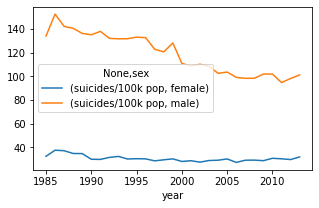

In [6]:
can_pivot_sex.plot(figsize=(5,3))

In [7]:
can_pivot_age = canada.pivot_table(columns=['age'], index=['year'], values=['suicides/100k pop'], aggfunc=np.sum)

can_pivot_age

suicides/100k pop                                                 \
age        15-24 years 25-34 years 35-54 years 5-14 years 55-74 years   
year                                                                    
1985             29.14       33.56       33.83       0.99       35.20   
1986             32.22       39.52       38.28       1.38       36.94   
1987             30.47       38.63       36.87       1.65       36.16   
1988             31.77       36.34       35.14       1.52       33.80   
1989             31.18       35.65       34.76       1.36       33.17   
1990             29.54       36.08       33.74       1.61       27.47   
1991             31.76       36.70       33.97       1.52       30.92   
1992             30.72       35.05       34.59       1.72       30.12   
1993             28.45       33.91       36.42       2.28       29.67   
1994             30.02       30.70       35.71       2.45       28.52   
1995             29.59       35.69       37.76       2.15       28.09   
1996             28.43       32.09       38.85       2.01       28.83   
1997             26.89       28.56       35.05       2.48       27.14   
1998             27.13       30.59       33.80       2.23       26.85   
1999             26.62       32.59       39.58       1.54       28.04   
2000             25.69       27.20       34.05       2.23       24.37   
2001             23.46       28.26       35.54       1.32       25.71   
2002             22.69       27.03       33.73       1.71       26.20   
2003             23.87       24.62       35.44       1.31       27.22   
2004             21.74       26.73       32.86       1.38       24.55   
2005             22.91       22.95       35.05       2.21       24.56   
2006             18.42       21.72       31.01       1.59       26.67   
2007             20.75       23.06       32.12       1.70       23.86   
2008             20.03       22.52       32.64       1.30       26.01   
2009             20.63       23.98       34.08       1.32       26.80   
2010             20.86       23.87       33.36       1.70       27.45   
2011             21.45       22.73       29.96       1.67       25.69   
2012             22.22       22.60       31.50       1.82       27.89   
2013             18.80       23.42       32.71       1.88       28.36   

                
age  75+ years  
year            
1985     33.74  
1986     41.77  
1987     35.55  
1988     36.81  
1989     34.86  
1990     36.58  
1991     32.91  
1992     31.40  
1993     33.29  
1994     34.51  
1995     30.24  
1996     32.68  
1997     31.31  
1998     29.52  
1999     30.07  
2000     25.46  
2001     23.14  
2002     26.37  
2003     24.81  
2004     24.40  
2005     26.16  
2006     27.02  
2007     25.96  
2008     25.09  
2009     23.86  
2010     25.43  
2011     23.52  
2012     21.85  
2013     27.92

### Canada: Age-based Suicide Rate ###

Since the early 90's, the 35-44 age group has higher suicide rates - this gap has continued to widen. This is partly due to a more noticable drop in suicide rates for other age graps over the last 25 years.

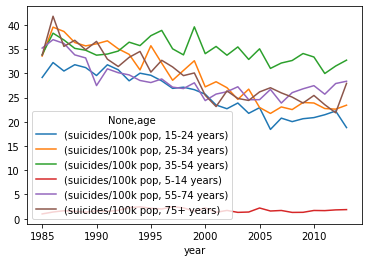

In [8]:
can_pivot_age.plot()

## Cleaning & Preparation of `Suicide` Dataset ##

There is a noticable dropoff of countries on a year-by-year basis. For example, 2014 has data for `78` countries whereas 2013 has `80` countries. The number of countries in 2015 are only `62`, which is a considerable dropoff. We will therefore focus on the year `2014` in our analysis and model.

*The non-availability of historical data for the countries not present in the `Suicide` dataset prevents us from using time series analysis for making future predictions for missing countries, which is one of our key objectives.*

**If we find a handful of statistically significant features, we will limit our model to finding the suicide rates for the missing countries the `suicide` dataset.**

In [9]:
# we will limit the dataset to 2014 as stated in the description above.
suicide_2014 = suicide[suicide['year'] == 2014]

# let's confirm that there are 78 countries in this dataset.
suicide_2014['country'].nunique()

78

In [10]:
suicide_2014.head()

country  year     sex          age  suicides_no  population  \
564  Antigua and Barbuda  2014  female  15-24 years            0        8537   
565  Antigua and Barbuda  2014  female  25-34 years            0        7578   
566  Antigua and Barbuda  2014  female  35-54 years            0       15273   
567  Antigua and Barbuda  2014  female   5-14 years            0        8296   
568  Antigua and Barbuda  2014  female  55-74 years            0        6085   

     suicides/100k pop             country-year  HDI for year  \
564                0.0  Antigua and Barbuda2014         0.783   
565                0.0  Antigua and Barbuda2014         0.783   
566                0.0  Antigua and Barbuda2014         0.783   
567                0.0  Antigua and Barbuda2014         0.783   
568                0.0  Antigua and Barbuda2014         0.783   

     gdp_for_year ($)   gdp_per_capita ($)    generation  
564      1,280,133,333               14093    Millenials  
565      1,280,133,333               14093    Millenials  
566      1,280,133,333               14093  Generation X  
567      1,280,133,333               14093  Generation Z  
568      1,280,133,333               14093       Boomers

In [11]:
# let's aggregate the dataset as per the relevant columns
# the aggregation function for HDI will need be `np.mean` whereas for the others it will be `np.sum`

pivot_dict = {'suicides_no': np.sum,
             'population': pd.Series.mode,
             'HDI for year': np.mean,
             'gdp_per': pd.Series.mode}

suicide_2014 = suicide_2014.pivot_table(['suicides_no', 'population', 'HDI for year', 'gdp_per_capita ($)'],
                                        index=['country'], aggfunc= 
                                        {'suicides_no': np.sum, 'population': np.sum, 'HDI for year': np.mean,
                                        'gdp_per_capita ($)': np.mean})

suicide_2014

HDI for year  gdp_per_capita ($)  population  \
country                                                                      
Antigua and Barbuda                  0.783               14093       90837   
Argentina                            0.836               13400    39276555   
Armenia                              0.733                4142     2803029   
Australia                            0.935               66809    21927587   
Austria                              0.885               54278     8141165   
Bahrain                              0.824               27503     1213966   
Belarus                              0.798                8849     8906977   
Belgium                              0.890               50173    10578848   
Belize                               0.715                5448      312780   
Bosnia and Herzegovina               0.733                5079     3654169   
Brazil                               0.755               12975   189285554   
Bulgaria                             0.782                8241     6883874   
Chile                                0.832               15883    16406867   
Colombia                             0.720                8591    44021800   
Costa Rica                           0.766               11485     4403674   
Croatia                              0.818               14299     4030452   
Cuba                                 0.769                7459    10813411   
Cyprus                               0.850               29024      804818   
Czech Republic                       0.870               20859     9963127   
Denmark                              0.923               66114     5339166   
Ecuador                              0.732                7116    14295145   
El Salvador                          0.666                3965     5696329   
Estonia                              0.861               21117     1241852   
Finland                              0.883               52832     5159944   
France                               0.888               47318    60275954   
Georgia                              0.754                4757     3470600   
Germany                              0.916               50167    77552369   
Greece                               0.865               22834    10380547   
Grenada                              0.750                9456       96393   
Guatemala                            0.627                4210    13947190   
Hungary                              0.828               14886     9412788   
Iceland                              0.899               56833      304472   
Ireland                              0.916               59634     4328043   
Israel                               0.894               41869     7366252   
Italy                                0.873               37035    58100676   
Japan                                0.891               40328   120274000   
Kazakhstan                           0.788               14351    15428844   
Kuwait                               0.816               43774     3715284   
Kyrgyzstan                           0.655                1465     5096430   
Latvia                               0.819               16544     1894041   
Lithuania                            0.839               17442     2781577   
Luxembourg                           0.892              126352      524940   
Malta                                0.839               27634      406525   
Mauritius                            0.777               11120     1151424   
Mexico                               0.756               11663   112692589   
Netherlands                          0.922               55325    15899508   
Nicaragua                            0.631                2199     5402424   
Norway                               0.944              103443     4827178   
Oman                                 0.793               22328     3631098   
Panama                               0.780          

In [12]:
suicide_2014['suicides_100k'] = suicide_2014['suicides_no'] / suicide_2014['population'] * 100000

# optional analysis: should we remove the countries with `0` suicide rates - will they skew the data?
# if so, we can use the following code to remove all `0` values:
## suicide_2014 = suicide_2014[suicide_2014['suicides_no'] != 0]

suicide_2014.head()

HDI for year  gdp_per_capita ($)  population  \
country                                                             
Antigua and Barbuda         0.783               14093       90837   
Argentina                   0.836               13400    39276555   
Armenia                     0.733                4142     2803029   
Australia                   0.935               66809    21927587   
Austria                     0.885               54278     8141165   

                     suicides_no  suicides_100k  
country                                          
Antigua and Barbuda            0       0.000000  
Argentina                   3231       8.226282  
Armenia                       58       2.069190  
Australia                   2891      13.184305  
Austria                     1314      16.140196

In [13]:
# we will create a function to find the code from the `wikipedia-iso-country-codes` dataset. 
# to do that, the function first uses a `SequenceMatcher` to match the country names in both datasets.

def code_finder(df, col):
    c_codes = pd.read_csv('/kaggle/input/iso-country-codes-global/wikipedia-iso-country-codes.csv')
    countries = []
    codes = []
    for country in col:
        highest_score = 0
        idx = 0
        for c in c_codes['English short name lower case']:
            score = SequenceMatcher(None, country, c).ratio()
            if score > highest_score:
                highest_score = score
                best_match = c
                code = c_codes.iloc[idx,2]
            idx += 1
        countries.append(country)
        codes.append(code)
    return countries, codes

countries, codes = code_finder(suicide_2014, suicide_2014.index)

# let's create a dataframe to depict the findings and merge them conveniently
codes_df = pd.DataFrame(index=countries)
codes_df['codes'] = codes

codes_df

codes
Antigua and Barbuda            ATG
Argentina                      ARG
Armenia                        ARM
Australia                      AUS
Austria                        AUT
Bahrain                        BHR
Belarus                        BLR
Belgium                        BEL
Belize                         BLZ
Bosnia and Herzegovina         BIH
Brazil                         BRA
Bulgaria                       BGR
Chile                          CHL
Colombia                       COL
Costa Rica                     CRI
Croatia                        HRV
Cuba                           CUB
Cyprus                         CYP
Czech Republic                 CZE
Denmark                        DNK
Ecuador                        ECU
El Salvador                    SLV
Estonia                        EST
Finland                        FIN
France                         FRA
Georgia                        GEO
Germany                        DEU
Greece                         GRC
Grenada                        GRD
Guatemala                      GTM
Hungary                        HUN
Iceland                        ISL
Ireland                        IRL
Israel                         ISR
Italy                          ITA
Japan                          JPN
Kazakhstan                     KAZ
Kuwait                         KWT
Kyrgyzstan                     KGZ
Latvia                         LVA
Lithuania                      LTU
Luxembourg                     LUX
Malta                          MLT
Mauritius                      MUS
Mexico                         MEX
Netherlands                    NLD
Nicaragua                      NIC
Norway                         NOR
Oman                           OMN
Panama                         PAN
Paraguay                       PRY
Poland                         POL
Portugal                       PRT
Puerto Rico                    PRI
Qatar                          QAT
Romania                        ROU
Russian Federation             RUS
Saint Lucia                    LCA
Saint Vincent and Grenadines   VCT
Serbia                         SRB
Seychelles                     SYC
Singapore                      SGP
Slovakia                       SVK
Slovenia                       SVN
South Africa                   ZAF
South Korea                    KOR
Spain                          ESP
Suriname                       SUR
Sweden                         SWE
Switzerland                    CHE
Thailand                       THA
Turkey                         TUR
Turkmenistan                   TKM
Ukraine                        UKR
United Kingdom                 GBR
United States                  USA
Uruguay                        URY
Uzbekistan                     UZB

In [14]:
merged_df = suicide_2014.merge(codes_df, how='left', left_index=True, right_index=True)
merged_df.head(10)

HDI for year  gdp_per_capita ($)  population  \
country                                                                
Antigua and Barbuda            0.783               14093       90837   
Argentina                      0.836               13400    39276555   
Armenia                        0.733                4142     2803029   
Australia                      0.935               66809    21927587   
Austria                        0.885               54278     8141165   
Bahrain                        0.824               27503     1213966   
Belarus                        0.798                8849     8906977   
Belgium                        0.890               50173    10578848   
Belize                         0.715                5448      312780   
Bosnia and Herzegovina         0.733                5079     3654169   

                        suicides_no  suicides_100k codes  
country                                                   
Antigua and Barbuda               0       0.000000   ATG  
Argentina                      3231       8.226282   ARG  
Armenia                          58       2.069190   ARM  
Australia                      2891      13.184305   AUS  
Austria                        1314      16.140196   AUT  
Bahrain                           9       0.741372   BHR  
Belarus                        1741      19.546475   BLR  
Belgium                        1899      17.950915   BEL  
Belize                           24       7.673125   BLZ  
Bosnia and Herzegovina          313       8.565559   BIH

In [15]:
# moving forward, we will use the country code as our index, particularly as it will make 
# our job easier working with geopandas
merged_df.set_index('codes', inplace=True)
merged_df.head(10)


HDI for year  gdp_per_capita ($)  population  suicides_no  \
codes                                                              
ATG           0.783               14093       90837            0   
ARG           0.836               13400    39276555         3231   
ARM           0.733                4142     2803029           58   
AUS           0.935               66809    21927587         2891   
AUT           0.885               54278     8141165         1314   
BHR           0.824               27503     1213966            9   
BLR           0.798                8849     8906977         1741   
BEL           0.890               50173    10578848         1899   
BLZ           0.715                5448      312780           24   
BIH           0.733                5079     3654169          313   

       suicides_100k  
codes                 
ATG         0.000000  
ARG         8.226282  
ARM         2.069190  
AUS        13.184305  
AUT        16.140196  
BHR         0.741372  
BLR        19.546475  
BEL        17.950915  
BLZ         7.673125  
BIH         8.565559

## Visualizing Suicide Rates Globally ##

We visually observe global suicide rates for the available countries in our dataset through a chloropleth map. Some key observations with regards to the visual data uncovered are as below:

* We have minimal information with regards to Africa and South Asia. This means that while regional data (continent, subregion) may still be useful, we will need a handful statistically significant features other than geographical ones to strengthen our model.
* Mackinder's heartland, which refers to Russia, Eastern Europe and some Central Asian (all former Soviet bloc states) have the highest suicide rates from the available data.
* Canada, which we studied in detail earlier, is missing most likely due to missing data for 2014.
* In the future, we should seriously consider developing a pipeline in which we can manually enter the year (to incorporate more countries) and see how our results differ.




In [16]:
# let's save our target column (for the map) to a variable
variable = 'suicides_100k'

shape_file = "../input/world-shapefiles/ne_10m_admin_0_countries.shp"
map_df = gpd.read_file(shape_file)


In [17]:
# Join chloropleth map data with our dataset
map_df = map_df.set_index('ADM0_A3').join(merged_df)

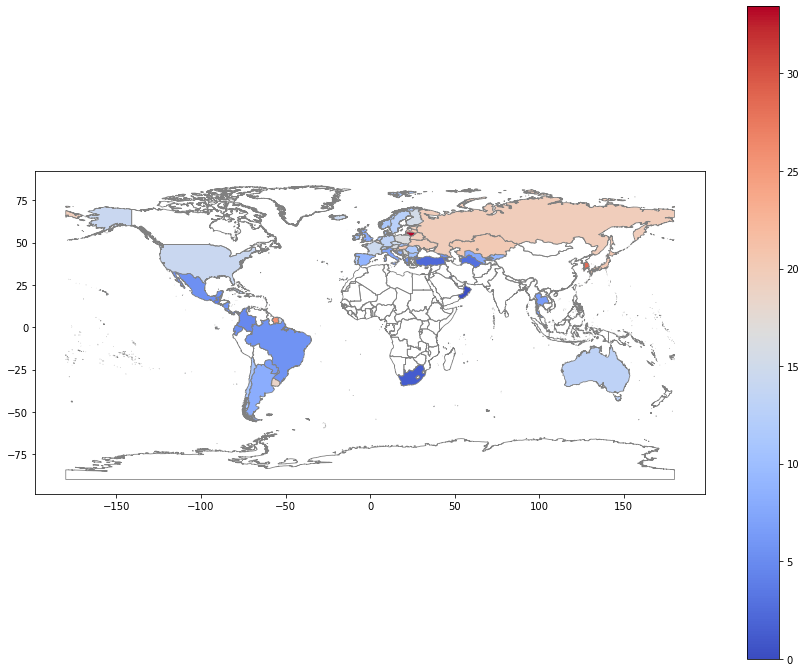

In [18]:
fig, ax = plt.subplots(1, figsize=(15,12))
map_df.plot(variable, cmap='coolwarm', linewidth=0.8, ax=ax, legend=True,  edgecolor="gray")

## Merging Socio-Economic Indicators For All Countries  ##

In [19]:
df = merged_df.copy()

In [20]:
cotw.head()

Country                               Region  Population  \
0     Afghanistan         ASIA (EX. NEAR EAST)             31056997   
1         Albania   EASTERN EUROPE                          3581655   
2         Algeria   NORTHERN AFRICA                        32930091   
3  American Samoa   OCEANIA                                   57794   
4         Andorra   WESTERN EUROPE                            71201   

   Area (sq. mi.) Pop. Density (per sq. mi.) Coastline (coast/area ratio)  \
0          647500                       48,0                         0,00   
1           28748                      124,6                         1,26   
2         2381740                       13,8                         0,04   
3             199                      290,4                        58,29   
4             468                      152,1                         0,00   

  Net migration Infant mortality (per 1000 births)  GDP ($ per capita)  \
0         23,06                             163,07               700.0   
1         -4,93                              21,52              4500.0   
2         -0,39                                 31              6000.0   
3        -20,71                               9,27              8000.0   
4           6,6                               4,05             19000.0   

  Literacy (%) Phones (per 1000) Arable (%) Crops (%) Other (%) Climate  \
0         36,0               3,2      12,13      0,22     87,65       1   
1         86,5              71,2      21,09      4,42     74,49       3   
2         70,0              78,1       3,22      0,25     96,53       1   
3         97,0             259,5         10        15        75       2   
4        100,0             497,2       2,22         0     97,78       3   

  Birthrate Deathrate Agriculture Industry Service  
0      46,6     20,34        0,38     0,24    0,38  
1     15,11      5,22       0,232    0,188   0,579  
2     17,14      4,61       0,101      0,6   0,298  
3     22,46      3,27         NaN      NaN     NaN  
4      8,71      6,25         NaN      NaN     NaN

In [21]:
# let's merge the CIA Factbook data with our dataset. 
# note that we need to set the 'Country' column as the index as our `code_finder` function works with the index.

cotw.set_index('Country', inplace=True)

In [22]:
countries, codes = code_finder(cotw, cotw.index)
cotw['codes'] = codes
cotw['country'] = countries

In [23]:
merged_df2 = df.join(cotw.set_index('codes'), how='outer')
merged_df2 = merged_df2[~merged_df2.index.duplicated(keep='first')]

# train = merged_df2[~merged_df2['suicides_100k'].isnull()]
# train.shape

In [24]:
df = merged_df2.copy()

In [25]:
df['Region'] = df['Region'].str.strip()
df['country'] = df['country'].str.strip()
df

HDI for year  gdp_per_capita ($)   population  suicides_no  \
codes                                                               
ABW             NaN                 NaN          NaN          NaN   
AFG             NaN                 NaN          NaN          NaN   
AGO             NaN                 NaN          NaN          NaN   
AIA             NaN                 NaN          NaN          NaN   
ALB             NaN                 NaN          NaN          NaN   
AND             NaN                 NaN          NaN          NaN   
ANT             NaN                 NaN          NaN          NaN   
ARE             NaN                 NaN          NaN          NaN   
ARG           0.836             13400.0   39276555.0       3231.0   
ARM           0.733              4142.0    2803029.0         58.0   
ASM             NaN                 NaN          NaN          NaN   
ATG           0.783             14093.0      90837.0          0.0   
AUS           0.935             66809.0   21927587.0       2891.0   
AUT           0.885             54278.0    8141165.0       1314.0   
AZE             NaN                 NaN          NaN          NaN   
BDI             NaN                 NaN          NaN          NaN   
BEL           0.890             50173.0   10578848.0       1899.0   
BEN             NaN                 NaN          NaN          NaN   
BFA             NaN                 NaN          NaN          NaN   
BGD             NaN                 NaN          NaN          NaN   
BGR           0.782              8241.0    6883874.0        724.0   
BHR           0.824             27503.0    1213966.0          9.0   
BHS             NaN                 NaN          NaN          NaN   
BIH           0.733              5079.0    3654169.0        313.0   
BLR           0.798              8849.0    8906977.0       1741.0   
BLZ           0.715              5448.0     312780.0         24.0   
BMU             NaN                 NaN          NaN          NaN   
BOL             NaN                 NaN          NaN          NaN   
BRA           0.755             12975.0  189285554.0      10631.0   
BRB             NaN                 NaN          NaN          NaN   
BTN             NaN                 NaN          NaN          NaN   
BWA             NaN                 NaN          NaN          NaN   
CAF             NaN                 NaN          NaN          NaN   
CAN             NaN                 NaN          NaN          NaN   
CHE           0.930             90809.0    7809621.0       1032.0   
CHL           0.832             15883.0   16406867.0       1789.0   
CHN             NaN                 NaN          NaN          NaN   
CIV             NaN                 NaN          NaN          NaN   
CMR             NaN                 NaN          NaN          NaN   
COK             NaN                 NaN          NaN          NaN   
COL           0.720              8591.0   44021800.0       2126.0   
COM             NaN                 NaN          NaN          NaN   
CPV             NaN                 NaN          NaN          NaN   
CRI           0.766             11485.0    4403674.0        268.0   
CUB           0.769              7459.0   10813411.0       1453.0   
CYM             NaN                 NaN          NaN          NaN   
CYP           0.850             29024.0     804818.0         44.0   
CZE           0.870             20859.0    9963127.0       1489.0   
DEU           0.916             50167.0   77552369.0      10217.0   
DJI             NaN                 NaN          NaN          NaN   
DMA             NaN                 NaN          NaN          NaN   
DNK           0.923             66114.0    5339166.0        629.0   
DOM             NaN                 NaN          NaN          NaN   
DZA             NaN                 NaN          NaN          NaN   
ECU           0.732              7116.0   14295145.0        734.0   
EGY             NaN                 NaN          NaN          NaN   
ERI  

In [26]:
# let's add country-wise religious data with our dataset
# we'll extract the data from 2010 as that is the latest availability data for all countries

# set 'state' as index to enable usability with `code_finder` function
religion_2010 = religion[religion['year'] == 2010]
religion_2010.set_index('state', inplace=True)

countries, codes = code_finder(religion_2010, religion_2010.index)
religion_2010['codes'] = codes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [27]:
religion_2010['state'] = religion_2010.index
religion_2010.set_index('codes', inplace=True)

religion_2010

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


year code  christianity_protestant  christianity_romancatholic  \
codes                                                                   
USA    2010  USA                119755961                    78397889   
CAN    2010  CAN                  7929127                    14497030   
BHS    2010  BHM                   211798                       43863   
CUB    2010  CUB                   550000                     6744696   
HTI    2010  HAI                   976083                     7027799   
DOM    2010  DOM                  1493497                     7168786   
JAM    2010  JAM                  1736000                       58000   
TTO    2010  TRI                   365100                      285670   
BRB    2010  BAR                   101335                       11464   
DMA    2010  DMA                    10950                       56210   
GRD    2010  GRN                    23852                       54209   
LCA    2010  SLU                    44116                      100204   
VCT    2010  SVG                    28288                       63544   
ATG    2010  AAB                    43710                        8690   
KNA    2010  SKN                     7500                       12675   
MEX    2010  MEX                 15886801                    92924489   
BLZ    2010  BLZ                    80829                      123010   
GTM    2010  GUA                  5529785                     7603454   
HND    2010  HON                  2560652                     4561162   
SLV    2010  SAL                  1990591                     4219188   
NIC    2010  NIC                  1350661                     3798734   
CRI    2010  COS                   453444                     3471000   
PAN    2010  PAN                   805444                     3361450   
COL    2010  COL                  6944250                    37961900   
VEN    2010  VEN                  4325100                    23067200   
GUY    2010  GUY                   191875                       61400   
SUR    2010  SUR                   142632                      129048   
ECU    2010  ECU                   284183                    12361961   
PER    2010  PER                  3675330                    23904351   
BRA    2010  BRA                 51122554                   113690456   
BOL    2010  BOL                  1373600                     8340600   
PRY    2010  PAR                   258212                     5680657   
CHL    2010  CHL                  1811913                    12954191   
ARG    2010  ARG                  4039999                    30299994   
URY    2010  URU                   369234                     1580995   
GBR    2010  UKG                  4525200                     4409825   
IRL    2010  IRE                    31442                     3861335   
NLD    2010  NTH                  2824128                     4485380   
BEL    2010  BEL                   108763                     6797746   
LUX    2010  LUX                     8500                      445137   
FRA    2010  FRN                  1254451                    40456051   
MCO    2010  MNC                      936                       24789   
LIE    2010  LIE                     3062                       27450   
CHE    2010  SWZ                  2193742                     3710000   
ESP    2010  SPN                  1200000                    35000000   
AND    2010  AND                      300                       73054   
PRT    2010  POR                    85140                     8780066   
DEU    2010  GMY                 25300000                    25700000   
POL    2010  POL                   145600                    33507000   
AUT    2010  AUS                   503386                     5369453   
HUN    2010  HUN                  1799569                     4677371   
CZE    2010  CZR                   174855                     2077857   
SVK    2010  SLO                   473787                     337

In [28]:
df_cols = set(df.columns)
religion_cols = set(religion_2010.columns)
col_intersect = set.intersection(df_cols, religion_cols)
col_intersect

{'population'}

In [29]:
religion_2010.drop('population', axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
df.head()

HDI for year  gdp_per_capita ($)  population  suicides_no  \
codes                                                              
ABW             NaN                 NaN         NaN          NaN   
AFG             NaN                 NaN         NaN          NaN   
AGO             NaN                 NaN         NaN          NaN   
AIA             NaN                 NaN         NaN          NaN   
ALB             NaN                 NaN         NaN          NaN   

       suicides_100k                Region  Population  Area (sq. mi.)  \
codes                                                                    
ABW              NaN   LATIN AMER. & CARIB       71891             193   
AFG              NaN  ASIA (EX. NEAR EAST)    31056997          647500   
AGO              NaN    SUB-SAHARAN AFRICA    12127071         1246700   
AIA              NaN   LATIN AMER. & CARIB       13477             102   
ALB              NaN        EASTERN EUROPE     3581655           28748   

      Pop. Density (per sq. mi.) Coastline (coast/area ratio) Net migration  \
codes                                                                         
ABW                        372,5                        35,49             0   
AFG                         48,0                         0,00         23,06   
AGO                          9,7                         0,13             0   
AIA                        132,1                        59,80         10,76   
ALB                        124,6                         1,26         -4,93   

      Infant mortality (per 1000 births)  GDP ($ per capita) Literacy (%)  \
codes                                                                       
ABW                                 5,89             28000.0         97,0   
AFG                               163,07               700.0         36,0   
AGO                               191,19              1900.0         42,0   
AIA                                21,03              8600.0         95,0   
ALB                                21,52              4500.0         86,5   

      Phones (per 1000) Arable (%) Crops (%) Other (%) Climate Birthrate  \
codes                                                                      
ABW               516,1      10,53         0     89,47       2     11,03   
AFG                 3,2      12,13      0,22     87,65       1      46,6   
AGO                 7,8       2,41      0,24     97,35     NaN     45,11   
AIA               460,0          0         0       100       2     14,17   
ALB                71,2      21,09      4,42     74,49       3     15,11   

      Deathrate Agriculture Industry Service      country  
codes                                                      
ABW        6,68       0,004    0,333   0,663        Aruba  
AFG       20,34        0,38     0,24    0,38  Afghanistan  
AGO        24,2       0,096    0,658   0,246       Angola  
AIA        5,34        0,04     0,18    0,78     Anguilla  
ALB        5,22       0,232    0,188   0,579      Albania

In [31]:
merged_df3 = df.join(religion_2010, how='left')
merged_df3 = merged_df3[~merged_df3.index.duplicated(keep='last')]
merged_df3[~merged_df3['suicides_100k'].isnull()]

HDI for year  gdp_per_capita ($)   population  suicides_no  \
codes                                                               
ARG           0.836             13400.0   39276555.0       3231.0   
ARM           0.733              4142.0    2803029.0         58.0   
ATG           0.783             14093.0      90837.0          0.0   
AUS           0.935             66809.0   21927587.0       2891.0   
AUT           0.885             54278.0    8141165.0       1314.0   
BEL           0.890             50173.0   10578848.0       1899.0   
BGR           0.782              8241.0    6883874.0        724.0   
BHR           0.824             27503.0    1213966.0          9.0   
BIH           0.733              5079.0    3654169.0        313.0   
BLR           0.798              8849.0    8906977.0       1741.0   
BLZ           0.715              5448.0     312780.0         24.0   
BRA           0.755             12975.0  189285554.0      10631.0   
CHE           0.930             90809.0    7809621.0       1032.0   
CHL           0.832             15883.0   16406867.0       1789.0   
COL           0.720              8591.0   44021800.0       2126.0   
CRI           0.766             11485.0    4403674.0        268.0   
CUB           0.769              7459.0   10813411.0       1453.0   
CYP           0.850             29024.0     804818.0         44.0   
CZE           0.870             20859.0    9963127.0       1489.0   
DEU           0.916             50167.0   77552369.0      10217.0   
DNK           0.923             66114.0    5339166.0        629.0   
ECU           0.732              7116.0   14295145.0        734.0   
ESP           0.876             31171.0   44172771.0       3911.0   
EST           0.861             21117.0    1241852.0        241.0   
FIN           0.883             52832.0    5159944.0        789.0   
FRA           0.888             47318.0   60275954.0       8881.0   
GBR           0.907             49906.0   60570482.0       4788.0   
GEO           0.754              4757.0    3470600.0        194.0   
GRC           0.865             22834.0   10380547.0        565.0   
GRD           0.750              9456.0      96393.0          0.0   
GTM           0.627              4210.0   13947190.0        512.0   
HRV           0.818             14299.0    4030452.0        722.0   
HUN           0.828             14886.0    9412788.0       1925.0   
IRL           0.916             59634.0    4328043.0        486.0   
ISL           0.899             56833.0     304472.0         44.0   
ISR           0.894             41869.0    7366252.0        382.0   
ITA           0.873             37035.0   58100676.0       4147.0   
JPN           0.891             40328.0  120274000.0      24357.0   
KAZ           0.788             14351.0   15428844.0       3119.0   
KGZ           0.655              1465.0    5096430.0        461.0   
KOR             NaN             29120.0   48465917.0      13834.0   
KWT           0.816             43774.0    3715284.0         68.0   
LCA           0.729              9372.0     165596.0         14.0   
LTU           0.839             17442.0    2781577.0        930.0   
LUX           0.892            126352.0     524940.0         67.0   
LVA           0.819             16544.0    1894041.0        382.0   
MEX           0.756             11663.0  112692589.0       6178.0   
MLT           0.839             27634.0     406525.0         32.0   
MUS           0.777             11120.0    1151424.0        120.0   
NIC           0.631              2199.0    5402424.0        311.0   
NLD           0.922             55325.0   15899508.0       1839.0   
NOR           0.944            103443.0    4827178.0        548.0   
OMN           0.793             22328.0    3631098.0          7.0   
PAN           0.780             14181.0    3520213.0        147.0   
POL           0.843             15119.0   36059630.0       5934.0   
PRI             NaN             29515.0    3470956.0        220.0   
PRT  

In [32]:
# we can see that 'South Korea' and 'Puerto Rico' have zero HDI. 
# let's replace these with real world values from 2014.

merged_df3.loc['KOR','HDI for year'] = 0.896
merged_df3.loc['PRI','HDI for year'] = 0.845

In [33]:
# let's create a new dataset so we can easily revert to this state if required
df = merged_df3.copy()

df

HDI for year  gdp_per_capita ($)   population  suicides_no  \
codes                                                               
ABW             NaN                 NaN          NaN          NaN   
AFG             NaN                 NaN          NaN          NaN   
AGO             NaN                 NaN          NaN          NaN   
AIA             NaN                 NaN          NaN          NaN   
ALB             NaN                 NaN          NaN          NaN   
AND             NaN                 NaN          NaN          NaN   
ANT             NaN                 NaN          NaN          NaN   
ARE             NaN                 NaN          NaN          NaN   
ARG           0.836             13400.0   39276555.0       3231.0   
ARM           0.733              4142.0    2803029.0         58.0   
ASM             NaN                 NaN          NaN          NaN   
ATG           0.783             14093.0      90837.0          0.0   
AUS           0.935             66809.0   21927587.0       2891.0   
AUT           0.885             54278.0    8141165.0       1314.0   
AZE             NaN                 NaN          NaN          NaN   
BDI             NaN                 NaN          NaN          NaN   
BEL           0.890             50173.0   10578848.0       1899.0   
BEN             NaN                 NaN          NaN          NaN   
BFA             NaN                 NaN          NaN          NaN   
BGD             NaN                 NaN          NaN          NaN   
BGR           0.782              8241.0    6883874.0        724.0   
BHR           0.824             27503.0    1213966.0          9.0   
BHS             NaN                 NaN          NaN          NaN   
BIH           0.733              5079.0    3654169.0        313.0   
BLR           0.798              8849.0    8906977.0       1741.0   
BLZ           0.715              5448.0     312780.0         24.0   
BMU             NaN                 NaN          NaN          NaN   
BOL             NaN                 NaN          NaN          NaN   
BRA           0.755             12975.0  189285554.0      10631.0   
BRB             NaN                 NaN          NaN          NaN   
BTN             NaN                 NaN          NaN          NaN   
BWA             NaN                 NaN          NaN          NaN   
CAF             NaN                 NaN          NaN          NaN   
CAN             NaN                 NaN          NaN          NaN   
CHE           0.930             90809.0    7809621.0       1032.0   
CHL           0.832             15883.0   16406867.0       1789.0   
CHN             NaN                 NaN          NaN          NaN   
CIV             NaN                 NaN          NaN          NaN   
CMR             NaN                 NaN          NaN          NaN   
COK             NaN                 NaN          NaN          NaN   
COL           0.720              8591.0   44021800.0       2126.0   
COM             NaN                 NaN          NaN          NaN   
CPV             NaN                 NaN          NaN          NaN   
CRI           0.766             11485.0    4403674.0        268.0   
CUB           0.769              7459.0   10813411.0       1453.0   
CYM             NaN                 NaN          NaN          NaN   
CYP           0.850             29024.0     804818.0         44.0   
CZE           0.870             20859.0    9963127.0       1489.0   
DEU           0.916             50167.0   77552369.0      10217.0   
DJI             NaN                 NaN          NaN          NaN   
DMA             NaN                 NaN          NaN          NaN   
DNK           0.923             66114.0    5339166.0        629.0   
DOM             NaN                 NaN          NaN          NaN   
DZA             NaN                 NaN          NaN          NaN   
ECU           0.732              7116.0   14295145.0        734.0   
EGY             NaN                 NaN          NaN          NaN   
ERI  

In [34]:
# let's identify and clean columns that require preparation

clean_cols = [
    'Pop. Density (per sq. mi.)', 'Arable (%)', 'Coastline (coast/area ratio)', 'Net migration',
    'Infant mortality (per 1000 births)', 'Literacy (%)', 'Phones (per 1000)',
    'Phones (per 1000)', 'Crops (%)','Other (%)','Birthrate','Deathrate',
    'Agriculture','Industry','Climate', 'Service' ]

def cleaner(val):
    out = str(val).replace(',','.')
    out = float(out)
    return out

for c in clean_cols:
    df[c] = df[c].map(lambda x: cleaner(x), na_action='ignore')

### Handle Missing Data ### 

In [35]:
df.loc['PRI','state'] = 'Puerto Rico'
df['Climate'] = df['Climate'].astype(float)

In [36]:
df.isnull().sum()

HDI for year                          138
gdp_per_capita ($)                    137
population                            137
suicides_no                           137
suicides_100k                         137
Region                                  0
Population                              0
Area (sq. mi.)                          0
Pop. Density (per sq. mi.)              0
Coastline (coast/area ratio)            0
Net migration                           2
Infant mortality (per 1000 births)      2
GDP ($ per capita)                      0
Literacy (%)                           16
Phones (per 1000)                       3
Arable (%)                              2
Crops (%)                               2
Other (%)                               2
Climate                                18
Birthrate                               2
Deathrate                               3
Agriculture                            14
Industry                               15
Service                           

In [37]:
null_cols = set(df.isnull().sum().sort_values().index)
numeric_columns = set(df.select_dtypes(np.number).columns)
null_cols = set.intersection(null_cols, numeric_columns)
null_cols.remove('suicides_100k')
null_cols

{'Agriculture',
 'Arable (%)',
 'Area (sq. mi.)',
 'Birthrate',
 'Climate',
 'Coastline (coast/area ratio)',
 'Crops (%)',
 'Deathrate',
 'GDP ($ per capita)',
 'HDI for year',
 'Industry',
 'Infant mortality (per 1000 births)',
 'Literacy (%)',
 'Net migration',
 'Other (%)',
 'Phones (per 1000)',
 'Pop. Density (per sq. mi.)',
 'Population',
 'Service',
 'ahmadiyya_percent',
 'alawite_percent',
 'anglican_percent',
 'animism_all',
 'animism_percent',
 'baha’i_all',
 'baha’i_percent',
 'buddhism_all',
 'buddhism_mahayana',
 'buddhism_other',
 'buddhism_percent',
 'buddhism_theravada',
 'christianity_all',
 'christianity_anglican',
 'christianity_easternorthodox',
 'christianity_other',
 'christianity_percent',
 'christianity_protestant',
 'christianity_romancatholic',
 'confucianism_all',
 'confucianism_percent',
 'conservative_percent',
 'dual_religion',
 'easternorthodox_percent',
 'gdp_per_capita ($)',
 'hinduism_all',
 'hinduism_percent',
 'ibadhi_percent',
 'islam_ahmadiyya',
 'i

In [38]:
df

HDI for year  gdp_per_capita ($)   population  suicides_no  \
codes                                                               
ABW             NaN                 NaN          NaN          NaN   
AFG             NaN                 NaN          NaN          NaN   
AGO             NaN                 NaN          NaN          NaN   
AIA             NaN                 NaN          NaN          NaN   
ALB             NaN                 NaN          NaN          NaN   
AND             NaN                 NaN          NaN          NaN   
ANT             NaN                 NaN          NaN          NaN   
ARE             NaN                 NaN          NaN          NaN   
ARG           0.836             13400.0   39276555.0       3231.0   
ARM           0.733              4142.0    2803029.0         58.0   
ASM             NaN                 NaN          NaN          NaN   
ATG           0.783             14093.0      90837.0          0.0   
AUS           0.935             66809.0   21927587.0       2891.0   
AUT           0.885             54278.0    8141165.0       1314.0   
AZE             NaN                 NaN          NaN          NaN   
BDI             NaN                 NaN          NaN          NaN   
BEL           0.890             50173.0   10578848.0       1899.0   
BEN             NaN                 NaN          NaN          NaN   
BFA             NaN                 NaN          NaN          NaN   
BGD             NaN                 NaN          NaN          NaN   
BGR           0.782              8241.0    6883874.0        724.0   
BHR           0.824             27503.0    1213966.0          9.0   
BHS             NaN                 NaN          NaN          NaN   
BIH           0.733              5079.0    3654169.0        313.0   
BLR           0.798              8849.0    8906977.0       1741.0   
BLZ           0.715              5448.0     312780.0         24.0   
BMU             NaN                 NaN          NaN          NaN   
BOL             NaN                 NaN          NaN          NaN   
BRA           0.755             12975.0  189285554.0      10631.0   
BRB             NaN                 NaN          NaN          NaN   
BTN             NaN                 NaN          NaN          NaN   
BWA             NaN                 NaN          NaN          NaN   
CAF             NaN                 NaN          NaN          NaN   
CAN             NaN                 NaN          NaN          NaN   
CHE           0.930             90809.0    7809621.0       1032.0   
CHL           0.832             15883.0   16406867.0       1789.0   
CHN             NaN                 NaN          NaN          NaN   
CIV             NaN                 NaN          NaN          NaN   
CMR             NaN                 NaN          NaN          NaN   
COK             NaN                 NaN          NaN          NaN   
COL           0.720              8591.0   44021800.0       2126.0   
COM             NaN                 NaN          NaN          NaN   
CPV             NaN                 NaN          NaN          NaN   
CRI           0.766             11485.0    4403674.0        268.0   
CUB           0.769              7459.0   10813411.0       1453.0   
CYM             NaN                 NaN          NaN          NaN   
CYP           0.850             29024.0     804818.0         44.0   
CZE           0.870             20859.0    9963127.0       1489.0   
DEU           0.916             50167.0   77552369.0      10217.0   
DJI             NaN                 NaN          NaN          NaN   
DMA             NaN                 NaN          NaN          NaN   
DNK           0.923             66114.0    5339166.0        629.0   
DOM             NaN                 NaN          NaN          NaN   
DZA             NaN                 NaN          NaN          NaN   
ECU           0.732              7116.0   14295145.0        734.0   
EGY             NaN                 NaN          NaN          NaN   
ERI  

In [39]:
# let's deal with numerical null values
# finding region-wise mean values for all empty columns for easy extraction 
df_pivot_region = df.pivot_table(null_cols, 'Region', aggfunc=np.mean)
df_pivot_region.head()

Agriculture  Arable (%)  Area (sq. mi.)  Birthrate  \
Region                                                                     
ASIA (EX. NEAR EAST)     0.163333   15.900000    8.303041e+05  21.278148   
BALTICS                  0.045000   30.310000    5.833833e+04   9.343333   
C.W. OF IND. STATES      0.190091   16.195455    2.006091e+06  18.051818   
EASTERN EUROPE           0.092167   30.982500    9.601850e+04  10.370909   
LATIN AMER. & CARIB      0.093512   10.866744    4.777107e+05  19.186279   

                       Climate  Coastline (coast/area ratio)  Crops (%)  \
Region                                                                    
ASIA (EX. NEAR EAST)  1.961538                     18.580370   3.955556   
BALTICS               3.000000                      3.116667   0.610000   
C.W. OF IND. STATES   2.550000                      0.101818   1.225455   
EASTERN EUROPE        3.111111                      1.035000   2.430833   
LATIN AMER. & CARIB   2.034884                     15.889767   4.540000   

                      Deathrate  GDP ($ per capita)  HDI for year  Industry  \
Region                                                                        
ASIA (EX. NEAR EAST)   7.555926         8285.185185      0.856250  0.310296   
BALTICS               12.630000        11300.000000      0.839667  0.293333   
C.W. OF IND. STATES   10.132727         4200.000000      0.729750  0.336636   
EASTERN EUROPE        10.284545         9808.333333      0.816200  0.309250   
LATIN AMER. & CARIB    6.404884         8560.465116      0.743450  0.259098   

                      Infant mortality (per 1000 births)  Literacy (%)  \
Region                                                                   
ASIA (EX. NEAR EAST)                           40.837037     79.340741   
BALTICS                                         8.103333     99.733333   
C.W. OF IND. STATES                            44.772727     98.690909   
EASTERN EUROPE                                 12.686667     97.088889   
LATIN AMER. & CARIB                            20.525814     91.204651   

                      Net migration  Other (%)  Phones (per 1000)  \
Region                                                              
ASIA (EX. NEAR EAST)       1.490000  80.144444         177.353846   
BALTICS                   -2.033333  69.080000         292.866667   
C.W. OF IND. STATES       -2.194545  82.579091         159.827273   
EASTERN EUROPE            -0.647500  66.587500         280.750000   
LATIN AMER. & CARIB       -1.293953  84.593488         261.833333   

                      Pop. Density (per sq. mi.)    Population   Service  \
Region                                                                     
ASIA (EX. NEAR EAST)                 1309.085185  1.348370e+08  0.526296   
BALTICS                                39.833333  2.394991e+06  0.661667   
C.W. OF IND. STATES                    49.863636  2.505589e+07  0.473364   
EASTERN EUROPE                        100.900000  9.992893e+06  0.598667   
LATIN AMER. & CARIB                   134.853488  1.305925e+07  0.645146   

                      ahmadiyya_percent  alawite_percent  anglican_percent  \
Region                                                                       
ASIA (EX. NEAR EAST)           0.000084         0.000000          0.001564   
BALTICS                        0.000000         0.000000          0.000000   
C.W. OF IND. STATES            0.000000         0.000000          0.000000   
EASTERN EUROPE                 0.000000         0.013333          0.000000   
LATIN AMER. & CARIB            0.000000         0.000000          0.047753   

                       animism_all  animism_percent     baha’i_all  \
Region                                                               
ASIA (EX. NEAR EAST)  2.923009e+06         0.027472  116043.120000   
BALTICS               1.634000e+03         0.001233      34.666667   
C.W. OF IND. STATES   2.023727e+03         0.0

In [40]:
df_pivot_region.loc['NORTHERN AFRICA']['HDI for year'] = .775
df_pivot_region

Agriculture  Arable (%)  Area (sq. mi.)  Birthrate  \
Region                                                                     
ASIA (EX. NEAR EAST)     0.163333   15.900000    8.303041e+05  21.278148   
BALTICS                  0.045000   30.310000    5.833833e+04   9.343333   
C.W. OF IND. STATES      0.190091   16.195455    2.006091e+06  18.051818   
EASTERN EUROPE           0.092167   30.982500    9.601850e+04  10.370909   
LATIN AMER. & CARIB      0.093512   10.866744    4.777107e+05  19.186279   
NEAR EAST                0.046571    9.072857    2.971433e+05  25.302143   
NORTHERN AFRICA          0.149750   10.890000    9.983375e+05  19.395000   
NORTHERN AMERICA         0.014000   11.426000    4.356494e+06  13.154000   
OCEANIA                  0.176800    8.031500    4.250376e+05  22.318421   
SUB-SAHARAN AFRICA       0.281239   11.685319    4.797185e+05  35.744583   
WESTERN EUROPE           0.044480   16.933333    1.325171e+05  10.553571   

                       Climate  Coastline (coast/area ratio)  Crops (%)  \
Region                                                                    
ASIA (EX. NEAR EAST)  1.961538                     18.580370   3.955556   
BALTICS               3.000000                      3.116667   0.610000   
C.W. OF IND. STATES   2.550000                      0.101818   1.225455   
EASTERN EUROPE        3.111111                      1.035000   2.430833   
LATIN AMER. & CARIB   2.034884                     15.889767   4.540000   
NEAR EAST             1.714286                      3.955714   4.520000   
NORTHERN AFRICA       1.666667                      0.347500   4.160000   
NORTHERN AMERICA      2.000000                     49.640000   0.048000   
OCEANIA               2.000000                    112.688500  15.439000   
SUB-SAHARAN AFRICA    1.880435                      5.421042   3.706596   
WESTERN EUROPE        3.095238                     25.970714   1.684815   

                      Deathrate  GDP ($ per capita)  HDI for year  Industry  \
Region                                                                        
ASIA (EX. NEAR EAST)   7.555926         8285.185185      0.856250  0.310296   
BALTICS               12.630000        11300.000000      0.839667  0.293333   
C.W. OF IND. STATES   10.132727         4200.000000      0.729750  0.336636   
EASTERN EUROPE        10.284545         9808.333333      0.816200  0.309250   
LATIN AMER. & CARIB    6.404884         8560.465116      0.743450  0.259098   
NEAR EAST              4.709286        11371.428571      0.826857  0.432571   
NORTHERN AFRICA        5.137500         5225.000000      0.775000  0.408000   
NORTHERN AMERICA       7.694000        26100.000000      0.915000  0.199333   
OCEANIA                5.817222         7910.000000      0.935000  0.223733   
SUB-SAHARAN AFRICA    15.216250         2429.166667      0.736000  0.263739   
WESTERN EUROPE         9.354643        27046.428571      0.893947  0.246083   

                      Infant mortality (per 1000 births)  Literacy (%)  \
Region                                                                   
ASIA (EX. NEAR EAST)                           40.837037     79.340741   
BALTICS                                         8.103333     99.733333   
C.W. OF IND. STATES                            44.772727     98.690909   
EASTERN EUROPE                                 12.686667     97.088889   
LATIN AMER. & CARIB                            20.525814     91.204651   
NEAR EAST                                      22.856429     79.083333   
NORTHERN AFRICA                                32.495000     63.400000   
NORTHERN AMERICA                                8.628000     97.750000   
OCEANIA                                        20.897222     88.700000   
SUB-SAHARAN AFRICA                             79.589792     61.955319   
WESTERN EUROPE                                  4.730357     98.391304   

                      Net migration  Other (%)  Phones (per 1000) 

In [41]:
# let's fill in the null values
def na_filler(df):
    # we iterate through each column that contains null values
    for col in null_cols:
        
        # extract all null value indexes for each column
        idx = df.Region[df.isnull()[col]].index
        
        # find out the `Region` value for each null value in each column
        region = df.Region[df.isnull()[col]]
        
        # find the mean value from our pivot table by indexing by region and column
        result = df_pivot_region.loc[region][col]
        
        #create a dictionary with index as key and region-based mean as value through dictionary comprehension
        result_dict = {idx[i]: result[i] for i in range(len(idx))}
        
        # assign result to missing values
        df[col] = df[col].fillna(result_dict)
    
na_filler(df)
        

### Regional Distribution of Suicide Rates ###

Let's take a quick peek into the regional distribution of suicide rates with a box-and-whisker plot. As we can see, there is clearly very little data for `North America` and `Oceania`.

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 <a list of 10 Text major ticklabel objects>)

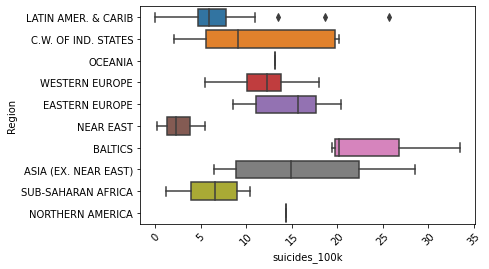

In [42]:
train = df[~df['suicides_100k'].isnull()]
sns.boxplot(x='suicides_100k', y='Region', data=train, fliersize=5)
plt.xticks(rotation=45)

In [43]:
regions = pd.get_dummies(df['Region'])
df = df.merge(regions, left_index=True, right_index=True)
df

HDI for year  gdp_per_capita ($)    population   suicides_no  \
codes                                                                 
ABW        0.743450        10631.900000  2.366932e+07   1455.500000   
AFG        0.856250        40138.000000  5.839230e+07  10624.500000   
AGO        0.736000        10921.000000  1.257825e+07    179.500000   
AIA        0.743450        10631.900000  2.366932e+07   1455.500000   
ALB        0.816200        14075.700000  1.028396e+07   1539.200000   
AND        0.893947        56205.526316  2.070690e+07   2292.526316   
ANT        0.743450        10631.900000  2.366932e+07   1455.500000   
ARE        0.826857        38465.000000  1.284493e+07    311.714286   
ARG        0.836000        13400.000000  3.927656e+07   3231.000000   
ARM        0.733000         4142.000000  2.803029e+06     58.000000   
ASM        0.935000        66809.000000  2.192759e+07   2891.000000   
ATG        0.783000        14093.000000  9.083700e+04      0.000000   
AUS        0.935000        66809.000000  2.192759e+07   2891.000000   
AUT        0.885000        54278.000000  8.141165e+06   1314.000000   
AZE        0.729750         7059.666667  2.700097e+07   4701.444444   
BDI        0.856250        40138.000000  5.839230e+07  10624.500000   
BEL        0.890000        50173.000000  1.057885e+07   1899.000000   
BEN        0.736000        10921.000000  1.257825e+07    179.500000   
BFA        0.736000        10921.000000  1.257825e+07    179.500000   
BGD        0.856250        40138.000000  5.839230e+07  10624.500000   
BGR        0.782000         8241.000000  6.883874e+06    724.000000   
BHR        0.824000        27503.000000  1.213966e+06      9.000000   
BHS        0.743450        10631.900000  2.366932e+07   1455.500000   
BIH        0.733000         5079.000000  3.654169e+06    313.000000   
BLR        0.798000         8849.000000  8.906977e+06   1741.000000   
BLZ        0.715000         5448.000000  3.127800e+05     24.000000   
BMU        0.915000        58531.000000  2.977497e+08  42769.000000   
BOL        0.743450        10631.900000  2.366932e+07   1455.500000   
BRA        0.755000        12975.000000  1.892856e+08  10631.000000   
BRB        0.743450        10631.900000  2.366932e+07   1455.500000   
BTN        0.856250        40138.000000  5.839230e+07  10624.500000   
BWA        0.736000        10921.000000  1.257825e+07    179.500000   
CAF        0.736000        10921.000000  1.257825e+07    179.500000   
CAN        0.915000        58531.000000  2.977497e+08  42769.000000   
CHE        0.930000        90809.000000  7.809621e+06   1032.000000   
CHL        0.832000        15883.000000  1.640687e+07   1789.000000   
CHN        0.856250        40138.000000  5.839230e+07  10624.500000   
CIV        0.736000        10921.000000  1.257825e+07    179.500000   
CMR        0.736000        10921.000000  1.257825e+07    179.500000   
COK        0.935000        66809.000000  2.192759e+07   2891.000000   
COL        0.720000         8591.000000  4.402180e+07   2126.000000   
COM        0.736000        10921.000000  1.257825e+07    179.500000   
CPV        0.736000        10921.000000  1.257825e+07    179.500000   
CRI        0.766000        11485.000000  4.403674e+06    268.000000   
CUB        0.769000         7459.000000  1.081341e+07   1453.000000   
CYM        0.743450        10631.900000  2.366932e+07   1455.500000   
CYP        0.850000        29024.000000  8.048180e+05     44.000000   
CZE        0.870000        20859.000000  9.963127e+06   1489.000000   
DEU        0.916000        50167.000000  7.755237e+07  10217.000000   
DJI        0.736000        10921.000000  1.257825e+07    179.500000   
DMA        0.743450        10631.900000  2.366932e+07   1455.500000   
DNK        0.923000        66114.000000  5.339166e+06    629.000000   
DOM        0.743450        10631.900000  2.366932e+07   1455.500000   
DZA        0.775000                 NaN           NaN           NaN   
ECU        0.732000         711

In [44]:
# Let's see which columns have a high correlation with our target variable of 'suicides_100k'
corr = df.corr()['suicides_100k'].sort_values(ascending=False)
corr

suicides_100k                         1.000000
Climate                               0.509368
noreligion_percent                    0.479992
Literacy (%)                          0.464745
Deathrate                             0.450884
BALTICS                               0.394772
HDI for year                          0.353918
Arable (%)                            0.349675
confucianism_all                      0.311853
confucianism_percent                  0.288946
suicides_no                           0.285950
Phones (per 1000)                     0.279661
noreligion_all                        0.228752
EASTERN EUROPE                        0.226471
otherbuddhism_percent                 0.212475
otherjudaism_percent                  0.211355
GDP ($ per capita)                    0.195134
buddhism_other                        0.194910
christianity_easternorthodox          0.192870
otherislam_percent                    0.188708
ASIA (EX. NEAR EAST)                  0.185616
religion_sump

In [45]:
# as expected from such a complex phenomenon like suicide, there is no feature that shows high correlation with our target variable
# let's try remove columns that may introduce excess noise when predicting suicide rates for missing countries

columns_significant_corr = list(corr.index[(corr > .17) | (corr < -.17)])
columns_significant_corr.append('state')

df = df.loc[:,columns_significant_corr]
df


suicides_100k   Climate  noreligion_percent  Literacy (%)  Deathrate  \
codes                                                                         
ABW              NaN  2.000000            0.083312     97.000000   6.680000   
AFG              NaN  1.000000            0.002000     36.000000  20.340000   
AGO              NaN  1.880435            0.017900     42.000000  24.200000   
AIA              NaN  2.000000            0.083312     95.000000   5.340000   
ALB              NaN  3.000000            0.150700     86.500000   5.220000   
AND              NaN  3.000000            0.079600    100.000000   6.250000   
ANT              NaN  2.000000            0.083312     96.700000   6.450000   
ARE              NaN  1.000000            0.013600     77.900000   4.400000   
ARG         8.226282  3.000000            0.120000     97.100000   7.550000   
ARM         2.069190  4.000000            0.034600     98.600000   8.230000   
ASM              NaN  2.000000            0.061336     97.000000   3.270000   
ATG         0.000000  2.000000            0.059000     89.000000   5.370000   
AUS        13.184305  1.000000            0.310100    100.000000   7.510000   
AUT        16.140196  3.000000            0.154200     98.000000   9.760000   
AZE              NaN  1.000000            0.019300     97.000000   9.750000   
BDI              NaN  2.000000            0.011800     93.900000   3.450000   
BEL        17.950915  3.000000            0.192000     98.000000  10.270000   
BEN              NaN  2.000000            0.033400     40.900000  12.220000   
BFA              NaN  2.000000            0.005000     26.600000  15.600000   
BGD              NaN  2.000000            0.000800     43.100000   8.270000   
BGR        10.517334  3.000000            0.047300     98.600000  14.270000   
BHR         0.741372  1.000000            0.000000     89.100000   4.140000   
BHS              NaN  2.000000            0.029000     95.600000   9.050000   
BIH         8.565559  4.000000            0.029300     97.088889   8.270000   
BLR        19.546475  4.000000            0.411000     99.600000  14.020000   
BLZ         7.673125  2.000000            0.156200     94.100000   5.720000   
BMU              NaN  2.000000            0.177150     98.000000   7.740000   
BOL              NaN  1.500000            0.140400     87.200000   7.530000   
BRA         5.616382  2.000000            0.085000     86.400000   6.170000   
BRB              NaN  2.000000            0.205000     97.400000   8.670000   
BTN              NaN  2.000000            0.000300     42.200000  12.700000   
BWA              NaN  1.000000            0.024900     79.800000  29.500000   
CAF              NaN  2.000000            0.012400     51.000000  18.650000   
CAN              NaN  2.000000            0.164300     97.000000   7.800000   
CHE        13.214470  3.000000            0.134200     99.000000   8.490000   
CHL        10.903971  3.000000            0.060000     96.200000   5.810000   
CHN              NaN  1.500000            0.325000     90.900000   6.970000   
CIV              NaN  2.000000            0.014359     50.900000  14.840000   
CMR              NaN  1.500000            0.007300     79.000000  13.470000   
COK              NaN  2.000000            0.061336     95.000000   5.817222   
COL         4.829425  2.000000            0.015000     92.500000   5.580000   
COM              NaN  2.000000            0.002400     56.500000   8.200000   
CPV              NaN  3.000000            0.017900     76.600000   6.550000   
CRI         6.085827  2.000000            0.100000     96.000000   4.360000   
CUB        13.437018  2.000000            0.131500     97.000000   7.220000   
CYM              NaN  2.000000            0.083312     98.000000   4.890000   
CYP         5.467075  3.000000            0.032000     97.600000   7.680000   
CZE        14.945107  3.000000            0.757500     99.900000  10.590000   
DEU        13.174324  3.000000            0.230000     99

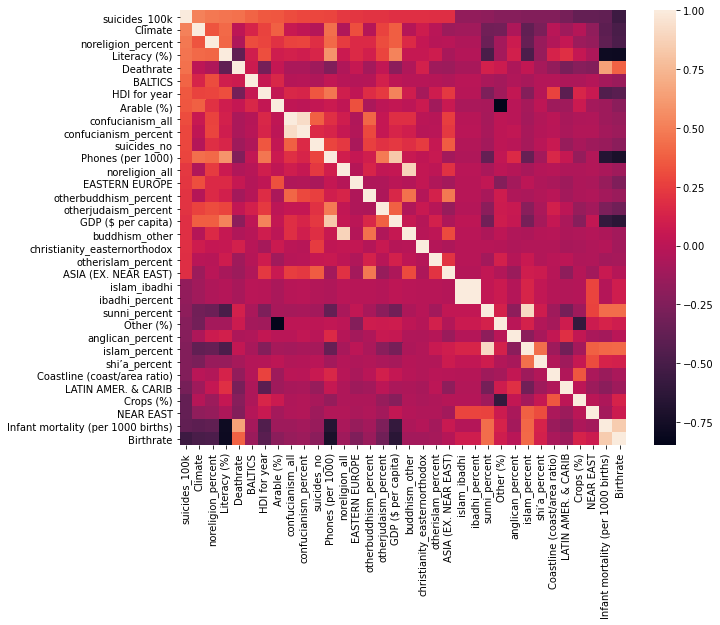

In [46]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df.corr())

## Devising A ML Model ##

Let's try to develop and train a ML model that can help us predict the suicide rates for the remaining countries that are missing from our initial dataset. 

In [47]:
df.columns

Index(['suicides_100k', 'Climate', 'noreligion_percent', 'Literacy (%)',
       'Deathrate', 'BALTICS', 'HDI for year', 'Arable (%)',
       'confucianism_all', 'confucianism_percent', 'suicides_no',
       'Phones (per 1000)', 'noreligion_all', 'EASTERN EUROPE',
       'otherbuddhism_percent', 'otherjudaism_percent', 'GDP ($ per capita)',
       'buddhism_other', 'christianity_easternorthodox', 'otherislam_percent',
       'ASIA (EX. NEAR EAST)', 'islam_ibadhi', 'ibadhi_percent',
       'sunni_percent', 'Other (%)', 'anglican_percent', 'islam_percent',
       'shi’a_percent', 'Coastline (coast/area ratio)', 'LATIN AMER. & CARIB',
       'Crops (%)', 'NEAR EAST', 'Infant mortality (per 1000 births)',
       'Birthrate', 'state'],
      dtype='object')

In [48]:
# let's remove columns we will not be needing in our machine learning model

# remove `suicide_no` we dont have any suicide data for data
# remove all non-percent religious columns so as not to overlap percentage columns
# we'll remove the 'shia' and 'sunni' columns and leave in the 'islam' column, as the latter is the sum of the prior two for several countries.
del_columns = ['confucianism_all', 'suicides_no', 'noreligion_all','buddhism_other',
               'christianity_easternorthodox','ibadhi_percent', 
               'islam_ibadhi','shi’a_percent', 'sunni_percent', 'otherislam_percent', 'ibadhi_percent',
              'Other (%)']

df.drop(del_columns, axis=1, inplace=True)

df.head()

suicides_100k   Climate  noreligion_percent  Literacy (%)  Deathrate  \
codes                                                                         
ABW              NaN  2.000000            0.083312          97.0       6.68   
AFG              NaN  1.000000            0.002000          36.0      20.34   
AGO              NaN  1.880435            0.017900          42.0      24.20   
AIA              NaN  2.000000            0.083312          95.0       5.34   
ALB              NaN  3.000000            0.150700          86.5       5.22   

       BALTICS  HDI for year  Arable (%)  confucianism_percent  \
codes                                                            
ABW          0       0.74345       10.53                   0.0   
AFG          0       0.85625       12.13                   0.0   
AGO          0       0.73600        2.41                   0.0   
AIA          0       0.74345        0.00                   0.0   
ALB          0       0.81620       21.09                   0.0   

       Phones (per 1000)  EASTERN EUROPE  otherbuddhism_percent  \
codes                                                             
ABW                516.1               0               0.000384   
AFG                  3.2               0               0.000100   
AGO                  7.8               0               0.000100   
AIA                460.0               0               0.000384   
ALB                 71.2               1               0.000000   

       otherjudaism_percent  GDP ($ per capita)  ASIA (EX. NEAR EAST)  \
codes                                                                   
ABW                0.000603             28000.0                     0   
AFG                0.000000               700.0                     1   
AGO                0.000000              1900.0                     0   
AIA                0.000603              8600.0                     0   
ALB                0.000000              4500.0                     0   

       anglican_percent  islam_percent  Coastline (coast/area ratio)  \
codes                                                                  
ABW            0.047753       0.012484                         35.49   
AFG            0.000000       0.995600                          0.00   
AGO            0.002000       0.010400                          0.13   
AIA            0.047753       0.012484                         59.80   
ALB            0.000000       0.630000                          1.26   

       LATIN AMER. & CARIB  Crops (%)  NEAR EAST  \
codes                                              
ABW                      1       0.00          0   
AFG                      0       0.22          0   
AGO                      0       0.24          0   
AIA                      1       0.00          0   
ALB                      0       4.42          0   

       Infant mortality (per 1000 births)  Birthrate        state  
codes                                                              
ABW                                  5.89      11.03          NaN  
AFG                                163.07      46.60  Afghanistan  
AGO                                191.19      45.11       Angola  
AIA                                 21.03      14.17          NaN  
ALB                                 21.52      15.11      Albania

In [49]:
df1 = df[~df['suicides_100k'].isnull()]
df2 = df[df['suicides_100k'].isnull()]

df_ml = pd.concat([df1, df2], axis=0)
print(df.shape, df_ml.shape)


(215, 24) (215, 24)


In [50]:
df_ml.reset_index(inplace=True)
codes = df_ml['codes']
df_ml

codes  suicides_100k   Climate  noreligion_percent  Literacy (%)  \
0     ARG       8.226282  3.000000            0.120000     97.100000   
1     ARM       2.069190  4.000000            0.034600     98.600000   
2     ATG       0.000000  2.000000            0.059000     89.000000   
3     AUS      13.184305  1.000000            0.310100    100.000000   
4     AUT      16.140196  3.000000            0.154200     98.000000   
5     BEL      17.950915  3.000000            0.192000     98.000000   
6     BGR      10.517334  3.000000            0.047300     98.600000   
7     BHR       0.741372  1.000000            0.000000     89.100000   
8     BIH       8.565559  4.000000            0.029300     97.088889   
9     BLR      19.546475  4.000000            0.411000     99.600000   
10    BLZ       7.673125  2.000000            0.156200     94.100000   
11    BRA       5.616382  2.000000            0.085000     86.400000   
12    CHE      13.214470  3.000000            0.134200     99.000000   
13    CHL      10.903971  3.000000            0.060000     96.200000   
14    COL       4.829425  2.000000            0.015000     92.500000   
15    CRI       6.085827  2.000000            0.100000     96.000000   
16    CUB      13.437018  2.000000            0.131500     97.000000   
17    CYP       5.467075  3.000000            0.032000     97.600000   
18    CZE      14.945107  3.000000            0.757500     99.900000   
19    DEU      13.174324  3.000000            0.230000     99.000000   
20    DNK      11.780866  3.000000            0.101100    100.000000   
21    ECU       5.134610  2.000000            0.085000     92.500000   
22    ESP       8.853871  3.000000            0.160000     97.900000   
23    EST      19.406499  3.000000            0.690300     99.800000   
24    FIN      15.290864  3.000000            0.166000    100.000000   
25    FRA      14.733902  4.000000            0.191500     99.000000   
26    GBR       7.904841  3.000000            0.261600     99.000000   
27    GEO       5.589812  3.000000            0.087600     99.000000   
28    GRC       5.442873  3.000000            0.026100     97.500000   
29    GRD       0.000000  2.000000            0.048100     98.000000   
30    GTM       3.670990  2.000000            0.045900     70.600000   
31    HRV      17.913624  3.111111            0.005800     98.500000   
32    HUN      20.450901  3.000000            0.271600     99.400000   
33    IRL      11.229094  3.000000            0.060500     98.000000   
34    ISL      14.451247  3.000000            0.032500     99.900000   
35    ISR       5.185812  3.000000            0.045000     95.400000   
36    ITA       7.137611  3.095238            0.186800     98.600000   
37    JPN      20.251260  3.000000            0.095000     99.000000   
38    KAZ      20.215384  4.000000            0.115200     98.400000   
39    KGZ       9.045548  2.500000            0.050000     97.000000   
40    KOR      28.543770  3.000000            0.454200     97.900000   
41    KWT       1.830277  1.000000            0.000000     83.500000   
42    LCA       8.454310  1.880435            0.059000     97.000000   
43    LTU      33.434271  3.000000            0.152100     99.600000   
44    LUX      12.763363  3.095238            0.049600    100.000000   
45    LVA      20.168518  3.000000            0.200600     99.800000   
46    MEX       5.482171  1.500000            0.027200     92.200000   
47    MLT       7.871595  3.095238            0.015000     92.800000   
48    MUS      10.421878  2.000000            0.007100     85.600000   
49    NIC       5.756675  2.000000            0.090000     67.500000   
50    NLD      11.566396  3.000000            0.340000     99.000000   
51    NOR      11.352388  3.000000            0.110500    100.000000   
52    OMN       0.192779  1.000000            0.000000     75.800000   
53    PAN       4.175884  2.000000            0.000000     92.600000   
54    POL      16.456076  3.000000          

In [51]:
train_y = df_ml.loc[:77, 'suicides_100k']

In [52]:
df_ml.drop(['codes', 'state', 'suicides_100k'], axis=1, inplace=True)
df_ml.head()

Climate  noreligion_percent  Literacy (%)  Deathrate  BALTICS  \
0      3.0              0.1200          97.1       7.55        0   
1      4.0              0.0346          98.6       8.23        0   
2      2.0              0.0590          89.0       5.37        0   
3      1.0              0.3101         100.0       7.51        0   
4      3.0              0.1542          98.0       9.76        0   

   HDI for year  Arable (%)  confucianism_percent  Phones (per 1000)  \
0         0.836       12.31                0.0000              220.4   
1         0.733       17.55                0.0000              195.7   
2         0.783       18.18                0.0000              549.9   
3         0.935        6.55                0.0026              565.5   
4         0.885       16.91                0.0000              452.2   

   EASTERN EUROPE  otherbuddhism_percent  otherjudaism_percent  \
0               0                 0.0002                0.0068   
1               0                 0.0000                0.0002   
2               0                 0.0000                0.0000   
3               0                 0.0247                0.0045   
4               0                 0.0000                0.0010   

   GDP ($ per capita)  ASIA (EX. NEAR EAST)  anglican_percent  islam_percent  \
0             11200.0                     0            0.0002         0.0151   
1              3500.0                     0            0.0000         0.0003   
2             11000.0                     0            0.2570         0.0000   
3             29000.0                     0            0.1560         0.0223   
4             30000.0                     0            0.0000         0.0475   

   Coastline (coast/area ratio)  LATIN AMER. & CARIB  Crops (%)  NEAR EAST  \
0                          0.18                    1       0.48          0   
1                          0.00                    0       2.30          0   
2                         34.54                    1       4.55          0   
3                          0.34                    0       0.04          0   
4                          0.00                    0       0.86          0   

   Infant mortality (per 1000 births)  Birthrate  
0                               15.18      16.73  
1                               23.28      12.07  
2                               19.46      16.93  
3                                4.69      12.14  
4                                4.66       8.74

In [53]:
df_normalized = df_ml.copy()

In [54]:
normalizer = Normalizer()
df_normalized = normalizer.fit_transform(df_normalized)
df_normalized.shape

(215, 22)

In [55]:
train_X = df_normalized[:78,:]
test_X = df_normalized[78:,:]

In [56]:
rf = RandomForestRegressor()
model = rf.fit(train_X, train_y)
result = model.predict(test_X)

In [57]:
predict_df = df_ml.copy()
predict_df['codes'] = codes
predict_df.loc[:78,'suicides_100k'] = train_y
predict_df.loc[78:,'suicides_100k'] = result
predict_df

Climate  noreligion_percent  Literacy (%)  Deathrate  BALTICS  \
0    3.000000            0.120000     97.100000   7.550000        0   
1    4.000000            0.034600     98.600000   8.230000        0   
2    2.000000            0.059000     89.000000   5.370000        0   
3    1.000000            0.310100    100.000000   7.510000        0   
4    3.000000            0.154200     98.000000   9.760000        0   
5    3.000000            0.192000     98.000000  10.270000        0   
6    3.000000            0.047300     98.600000  14.270000        0   
7    1.000000            0.000000     89.100000   4.140000        0   
8    4.000000            0.029300     97.088889   8.270000        0   
9    4.000000            0.411000     99.600000  14.020000        0   
10   2.000000            0.156200     94.100000   5.720000        0   
11   2.000000            0.085000     86.400000   6.170000        0   
12   3.000000            0.134200     99.000000   8.490000        0   
13   3.000000            0.060000     96.200000   5.810000        0   
14   2.000000            0.015000     92.500000   5.580000        0   
15   2.000000            0.100000     96.000000   4.360000        0   
16   2.000000            0.131500     97.000000   7.220000        0   
17   3.000000            0.032000     97.600000   7.680000        0   
18   3.000000            0.757500     99.900000  10.590000        0   
19   3.000000            0.230000     99.000000  10.620000        0   
20   3.000000            0.101100    100.000000  10.360000        0   
21   2.000000            0.085000     92.500000   4.230000        0   
22   3.000000            0.160000     97.900000   9.720000        0   
23   3.000000            0.690300     99.800000  13.250000        1   
24   3.000000            0.166000    100.000000   9.860000        0   
25   4.000000            0.191500     99.000000   9.140000        0   
26   3.000000            0.261600     99.000000  10.130000        0   
27   3.000000            0.087600     99.000000   9.230000        0   
28   3.000000            0.026100     97.500000  10.240000        0   
29   2.000000            0.048100     98.000000   6.880000        0   
30   2.000000            0.045900     70.600000   5.200000        0   
31   3.111111            0.005800     98.500000  11.480000        0   
32   3.000000            0.271600     99.400000  13.110000        0   
33   3.000000            0.060500     98.000000   7.820000        0   
34   3.000000            0.032500     99.900000   6.720000        0   
35   3.000000            0.045000     95.400000   6.180000        0   
36   3.095238            0.186800     98.600000  10.400000        0   
37   3.000000            0.095000     99.000000   9.160000        0   
38   4.000000            0.115200     98.400000   9.420000        0   
39   2.500000            0.050000     97.000000   7.080000        0   
40   3.000000            0.454200     97.900000   5.850000        0   
41   1.000000            0.000000     83.500000   2.410000        0   
42   1.880435            0.059000     97.000000   6.530000        0   
43   3.000000            0.152100     99.600000  10.980000        1   
44   3.095238            0.049600    100.000000   8.410000        0   
45   3.000000            0.200600     99.800000  13.660000        1   
46   1.500000            0.027200     92.200000   4.740000        0   
47   3.095238            0.015000     92.800000   8.100000        0   
48   2.000000            0.007100     85.600000   6.860000        0   
49   2.000000            0.090000     67.500000   4.450000        0   
50   3.000000            0.340000     99.000000   8.680000        0   
51   3.000000            0.110500    100.000000   9.400000        0   
52   1.000000            0.000000     75.800000   3.810000        0   
53   2.000000            0.000000     92.600000   5.360000        0   
54   3.000000            0.080000     99.800000   9.890000        0   
55   2.000000            0.083

In [58]:
variable = 'suicides_100k'
map_df = gpd.read_file(shape_file)

merged_df = map_df.set_index('ADM0_A3').join(predict_df.set_index('codes'))

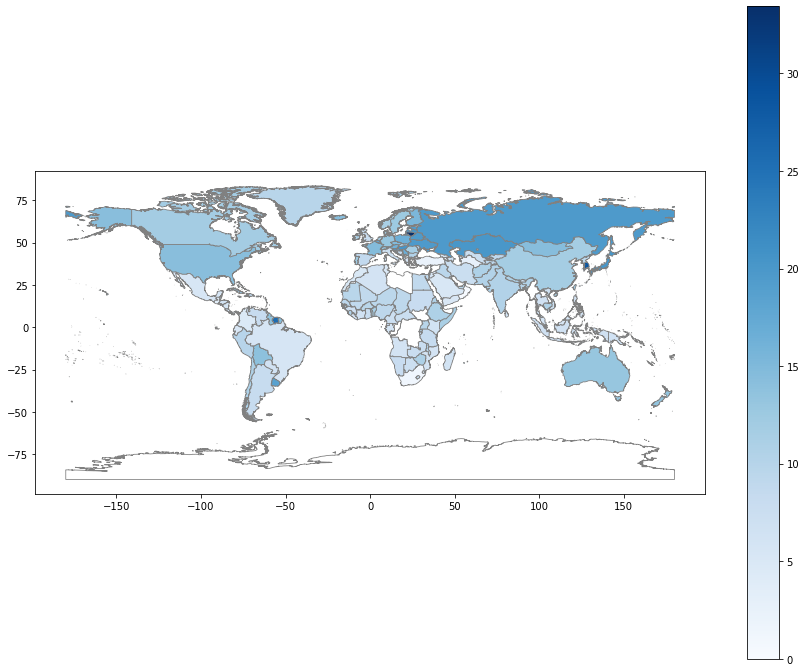

In [59]:
fig, ax = plt.subplots(1, figsize=(20,15))
merged_df.plot(variable, cmap='Blues', linewidth=0.8, ax=ax, legend=True, edgecolor="gray")

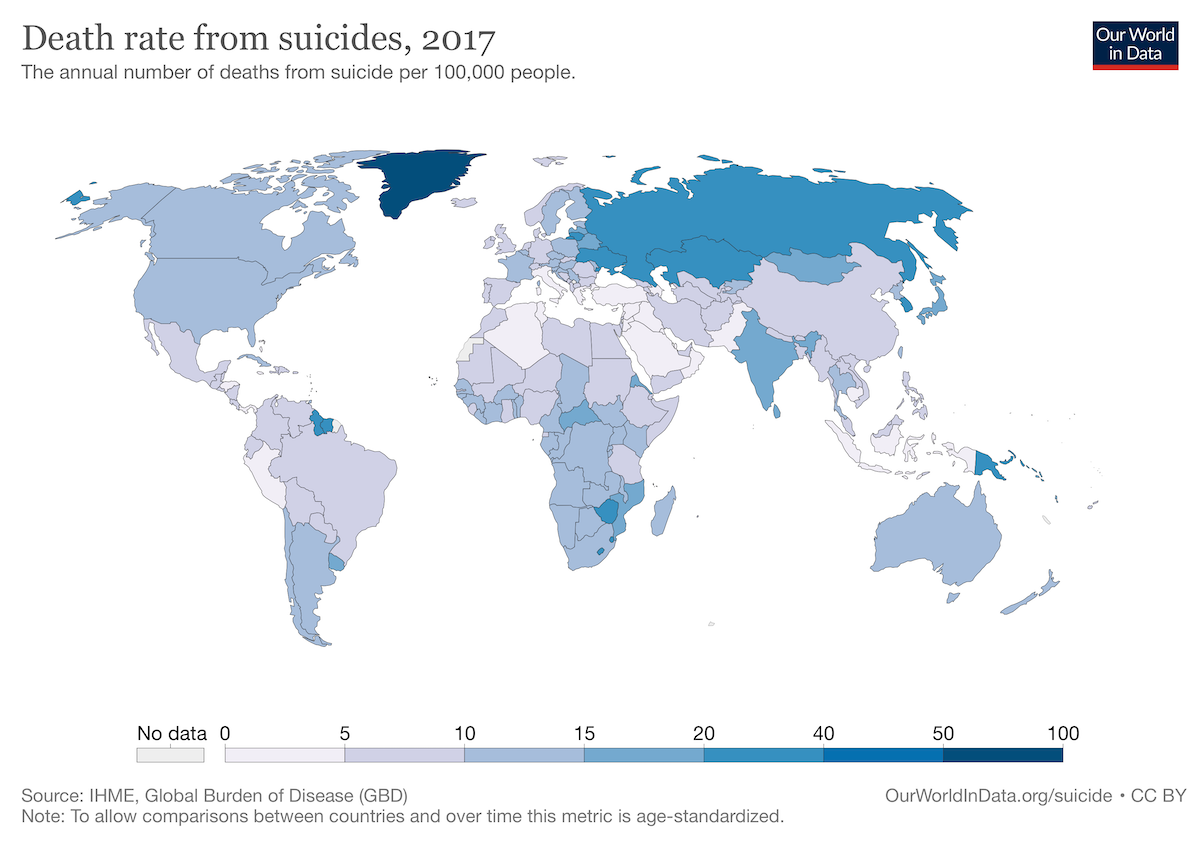


![](http://)